# Prototypical network on few-shot learning for image classification

為AI CUP 2022秋季競賽，農地作物現況調查影像辨識競賽-秋季賽：AI作物影像判釋，

目標是將各種農作物正確分類。

https://aidea-web.tw/topic/5f632f38-7213-4d4d-bea3-117ff13c1afb

# 1.dataBase

主辦給的資料集如下，共有34個類，每個類有2041張照片，

![jupyter](1.png)

![jupyter](2.png)

為了符合網路使用的訓練資料格式，重新整理各類圖片，

每個類不是由名字命名，而是編號0-33，

每個類裡的每張照片由a_b命名，a代表類別，b代表第幾張圖片(0-2040)。

原本可以使用其他更常見的執行分類任務用的神經網路，但是因為數據集太大(超過170G)，

電腦的GPU內存不夠(4Gb)，根本訓練不出來，所以才考慮使用meta learning訓練。

(將訓練、測試、驗證資料集分開跑，是因為一起跑的話太花時間)

In [122]:
import os
import numpy as np
from math import floor
from bs4 import BeautifulSoup
import shutil

input_path="D:/Donload/dataset/"
soft = True
fold=["trian","test","val"]

number_of_classes = len([name for name in os.listdir("D:/Donload/dataset") if os.path.isdir("D:/Donload/dataset")])
number_of_images_by_class = np.array([ len(os.listdir(os.path.join("D:/Donload/dataset/",subfolder))) for ix, subfolder in enumerate([ subfolder for id, subfolder in enumerate(os.listdir("D:/Donload/dataset"))])])
min = np.min(number_of_images_by_class)
number_of_images_to_select = [ (x[0], floor(x[1] * min)) for x in [ ('train', 0.6) ,('test', 0.2),('eval', 0.2)]]


#創建符合網路訓練要用的trian set
all_image_class = np.array([ (subfolder,os.listdir(os.path.join("D:/Donload/dataset/", subfolder))) for ix, subfolder in enumerate( [subfolder for id, subfolder in enumerate(os.listdir("D:/Donload/dataset"))])])    
   
name_of_set = number_of_images_to_select[0][0]
number_of_images = number_of_images_to_select[0][1]
            
for ix , image_tuple in enumerate(all_image_class):
    clasz = image_tuple[0]
    image_set = image_tuple[1]
    os.makedirs(os.path.join("D:/Donload/data1/",name_of_set,str(ix)))
    for p in range(1224):
        shutil.copyfile("D:/Donload/dataset/"+clasz+"/"+image_set[p], os.path.join("D:/Donload/data1/",name_of_set,str(ix),str(ix)+"_"+str(p)+".jpg"))


C:\Users\swps6\anaconda3\envs\tensorflowgpuenc\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FileNotFoundError: [Errno 2] No such file or directory: 'D:/Donload/dataset/train/asparagus'

In [125]:
#創建符合網路訓練要用的test set
import os
import numpy as np
from math import floor
from bs4 import BeautifulSoup
import shutil

name_of_set = number_of_images_to_select[1][0]
number_of_images = number_of_images_to_select[1][1]
            
for ix , image_tuple in enumerate(all_image_class):
    clasz = image_tuple[0]
    image_set = image_tuple[1]
    os.makedirs(os.path.join("D:/Donload/data1/",name_of_set,str(ix)))
    for p in range(1225,1633):
        shutil.copyfile("D:/Donload/dataset/"+clasz+"/"+image_set[p], os.path.join("D:/Donload/data1/",name_of_set,str(ix),str(ix)+"_"+str(p)+".jpg"))


IndexError: list index out of range

In [124]:
#創建符合網路訓練要用的val set
import os
import numpy as np
from math import floor
from bs4 import BeautifulSoup
import shutil

name_of_set = number_of_images_to_select[2][0]
number_of_images = number_of_images_to_select[2][1]
            
for ix , image_tuple in enumerate(all_image_class):
    clasz = image_tuple[0]
    image_set = image_tuple[1]
    os.makedirs(os.path.join("D:/Donload/data1/",name_of_set,str(ix)))
    for p in range(1634,2041):
        shutil.copyfile("D:/Donload/dataset/"+clasz+"/"+image_set[p], os.path.join("D:/Donload/data1/",name_of_set,str(ix),str(ix)+"_"+str(p)+".jpg"))


IndexError: list index out of range

訓練資料佔60%，測試資料佔20%，驗證資料佔20%。

In [42]:
number_of_images_to_select

[('train', 1224), ('test', 408), ('eval', 408)]

訓練網路的代碼，來自下列網址：

https://github.com/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

from pathlib import Path
from torch.utils.data import Dataset
# from torchvision.io import read_image
from PIL import Image


def _validate_root_dir(root):
    # todo: raise exception or warning
    pass

def _validate_train_flag(train: bool, valid: bool, test: bool):
    assert [train, valid, test].count(True)==1, "one of train, valid & test must be true."        

class CustomDataset(Dataset):        
    def __init__(self, root,
                 train: bool = False, valid: bool = False, test: bool = False,
                 transform=None, target_transform=None,):
        _validate_root_dir(root)
        _validate_train_flag(train, valid, test)        
        self.transform = transform
        self.target_transform = target_transform
        if train:
            self.data_dir = Path(root)/"train"
        elif valid:
            self.data_dir = Path(root)/'eval'
        elif test:
            self.data_dir = Path(root)/'test' 
          
        self._image_paths = sorted(
            list(self.data_dir.glob("**/*.jpg"))+
            list(self.data_dir.glob("**/*.jpeg"))+
            list(self.data_dir.glob("**/*.png")))
        self._image_labels = [int(i.parent.name) for i in self._image_paths]
        assert len(self._image_paths)==len(self._image_labels)
    
    def __len__(self):
        return len(self._image_paths)
    
    def __getitem__(self, idx):
        x = Image.open(str(self._image_paths[idx]))
        y = self._image_labels[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(x)
        return x, y
    
    def get_labels(self):
        return self._image_labels

創建訓練要使用的train_set與valid_set

In [3]:
image_size = 128
data_dir = "D:/Donload/data1"
# train set is list of (x, y) 
# where x is single image and y is label corresponding to it.
train_set = CustomDataset(
    root=data_dir,
    train=True,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.5), int(image_size * 1.5)]),
            transforms.RandomPerspective(0.5, 0.8),
            transforms.CenterCrop(image_size),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.15, saturation=0, hue=0,
            ),
            transforms.ToTensor(),
        ]
    ),
)
valid_set = CustomDataset(
    root=data_dir,
    valid=True,
    transform=transforms.Compose(
        [
            # If images have 1 channel, our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
)

In [4]:
len(train_set)

39168

但是常規的 PyTorch 數據加載器將提供成批的圖像，而不考慮它們的標籤或者它們是query set還是support set。

在元學習中，需要

1.在給定數量的類之間均勻分佈的圖像：自定義採樣器TaskSampler，從數據集中採樣 n_way 類，然後為每個類採樣 n_shot、n_query 圖像（每批中總共 n_way * (n_shot n_query) 圖像）。

2.將資料分成query set和support set：自定義的 collate 函數來替換內置的 PyTorch collate_fn。 

In [10]:
N_WAY = 5 # 5  # Number of classes in a task
N_SHOT = 5 # 5  # Number of images per class in the support set
N_QUERY = 10 # 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100 

valid_sampler = TaskSampler(
    valid_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

valid_loader = DataLoader(
    valid_set,
    batch_sampler=valid_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=valid_sampler.episodic_collate_fn,
)

創建了DataLoader和TaskSampler，將為網路提供5-way 5-shot的task。

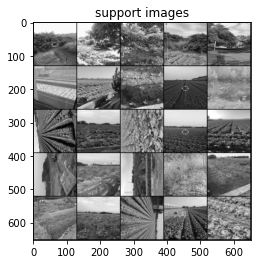

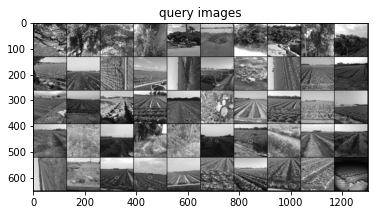

In [11]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(valid_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)


In [17]:
example_query_labels

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])

# 創建Prototypical Networks

In [12]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrototypicalNetworks(convolutional_network).cuda()
#model = PrototypicalNetworks(convolutional_network).to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

先用example_support_images和example_query_images測試並分別列出網路的預測結果與真實label

In [19]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{example_query_labels[i]} / {example_predicted_labels[i]}"
    )

Ground Truth / Predicted
4 / 4
4 / 4
4 / 4
4 / 0
4 / 4
4 / 2
4 / 4
4 / 3
4 / 4
4 / 4
3 / 3
3 / 3
3 / 0
3 / 3
3 / 0
3 / 3
3 / 4
3 / 0
3 / 1
3 / 3
2 / 4
2 / 3
2 / 0
2 / 1
2 / 1
2 / 0
2 / 1
2 / 4
2 / 2
2 / 3
0 / 0
0 / 4
0 / 3
0 / 4
0 / 4
0 / 4
0 / 4
0 / 4
0 / 3
0 / 3
1 / 2
1 / 4
1 / 3
1 / 3
1 / 3
1 / 1
1 / 3
1 / 1
1 / 0
1 / 3


再用所有驗證資料集看看網路的預測能力如何，結果是38.98%，訓練前的預測結果不好。

In [20]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
             model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
#            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(valid_loader)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [33:11<00:00, 19.92s/it]

Model tested on 100 tasks. Accuracy: 38.98%


# 訓練元學習算法(Prototypical Networks)

包含 40000 個小樣本分類任務的數據加載器。

In [21]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)


這裡使用的損失函數為交叉熵(cross entropy)，優化器為Adam，以及一個擬合方法。 

該方法將分類任務作為輸入(支持集和查詢集)，來自支持集預測的查詢集的標籤，

然後它將預測標籤與真實查詢標籤進行比較，這給了我們一個損失值，並更新模型的參數。

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
         support_images.cuda(), support_labels.cuda(), query_images.cuda()
#        support_images.to(device), support_labels.to(device), query_images.to(device)
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()


開始訓練網路

(這裡訓練到20000次時，已經經過4天3夜，因為太晚才報名，導致訓練網路的時間不夠，到比賽結束都沒有訓練完，之後會再找機會讓模型跑完，或者減小訓練次數看看)

In [23]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  0%|▏                                                            | 100/40000 [1:06:33<442:38:32, 39.94s/it, loss=1.14]


KeyboardInterrupt: 

# 測試網路性能

將test_set輸入訓練好的網路，看看網路辨識的能力如何

In [28]:
test_set = CustomDataset(
    root=data_dir,
    test=True,
    transform=transforms.Compose(
        [
            # If images have 1 channel, our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
)

N_WAY = 5 # 5  # Number of classes in a task
N_SHOT = 5 # 5  # Number of images per class in the support set
N_QUERY = 10 # 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 500 

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

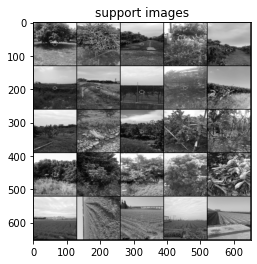

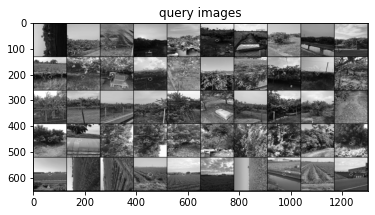

In [29]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

輸出使用test_set時網路的分類正確率

In [ ]:
evaluate(test_loader)